### Реализация развертывания модели на платформе gradio 
### ссылка https://gradio.app/quickstart/

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from plotcm import plot_confusion_matrix

import pdb
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
#Creata seed fucntions
def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# Ссылки на данные

In [5]:
image_path = "Dataset\pizza_steak_sushi_20"
train_dir = image_path + "/train"
test_dir = image_path + "/test"

# Загрузка модели EffNetB2 

1. Загружаем модель
2. Получаем трансформ для предобратки данных
3. Замораживаем все слои (нет необходимости снова их обучать)
4. Адаптируем последние слои под наш набор данных (пицца, стейки, роллы)
5. Подготовим данные
6. Обучим (загруженную модель) на нашем наборе данных
7. Оценим результаты обучения модели (кривые, матрица ошибок)
8. Сохранение модели на диск

In [10]:
# Step 1 - 4
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [12]:
# Step 5
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [13]:
# Step 6
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9849 | train_acc: 0.5771 | test_loss: 0.7385 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7111 | train_acc: 0.8521 | test_loss: 0.5865 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5859 | train_acc: 0.8979 | test_loss: 0.4891 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4499 | train_acc: 0.9104 | test_loss: 0.4341 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4278 | train_acc: 0.9083 | test_loss: 0.3922 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4405 | train_acc: 0.8833 | test_loss: 0.3524 | test_acc: 0.9597
Epoch: 7 | train_loss: 0.4262 | train_acc: 0.8812 | test_loss: 0.3269 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3836 | train_acc: 0.9083 | test_loss: 0.3478 | test_acc: 0.9352
Epoch: 9 | train_loss: 0.3739 | train_acc: 0.8833 | test_loss: 0.3146 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3668 | train_acc: 0.8667 | test_loss: 0.2817 | test_acc: 0.9688


In [18]:
# Step 7
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from tqdm.auto import tqdm
from helper_functions import plot_loss_curves


def get_train_inf(models,
                  result,
                  test_dataloader,
                  normalize = False,
                  classes = ('pizza', 'steak', 'sushi')
                  ):
    #get plot loss and accuracy
    plot_loss_curves(result)
    
    # get Confusion Matrix
    y_preds = []
    models.eval()
    with torch.inference_mode(): # get predict data
      for X, y in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        x = X.unsqueeze(dim=0)
        y_logit = models(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) 
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
    # Concatenate list of predictions into a tensor
    y_pred_tensor = torch.cat(y_preds)
    
    
    y_pred = []
    y_true = []
    
    # iterate over test data
    for inputs, labels in test_dataloader:
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 

    # constant for classes
  

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_tensor)
    if normalize:
        value = cf_matrix/np.sum(cf_matrix)
    else:
        value = cf_matrix

    df_cm = pd.DataFrame(value, index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    plt.title('Confusion Matrix')
    sn.heatmap(df_cm, annot=True)
    
    
    


Making predictions:   0%|          | 0/5 [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "C:\Users\Tosch\anaconda3\envs\tf\lib\multiprocessing\queues.py", line 239, in _feed
    reader_close()
  File "C:\Users\Tosch\anaconda3\envs\tf\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "C:\Users\Tosch\anaconda3\envs\tf\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] Неверный дескриптор

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Tosch\anaconda3\envs\tf\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Tosch\anaconda3\envs\tf\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Tosch\anaconda3\envs\tf\lib\multiprocessing\queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


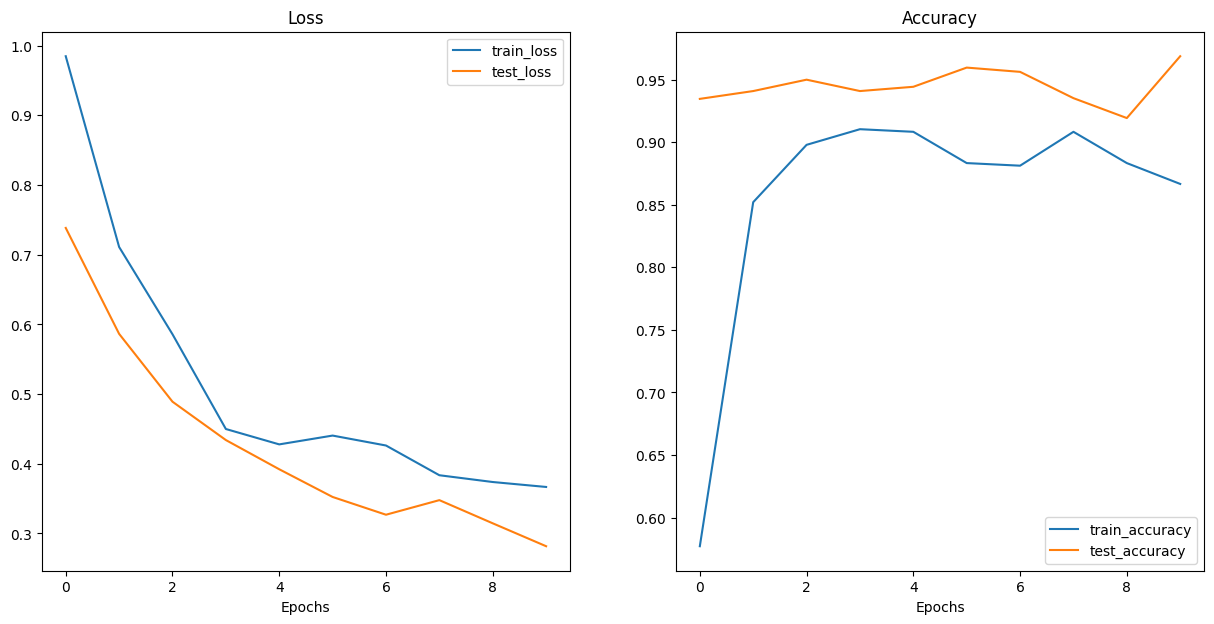

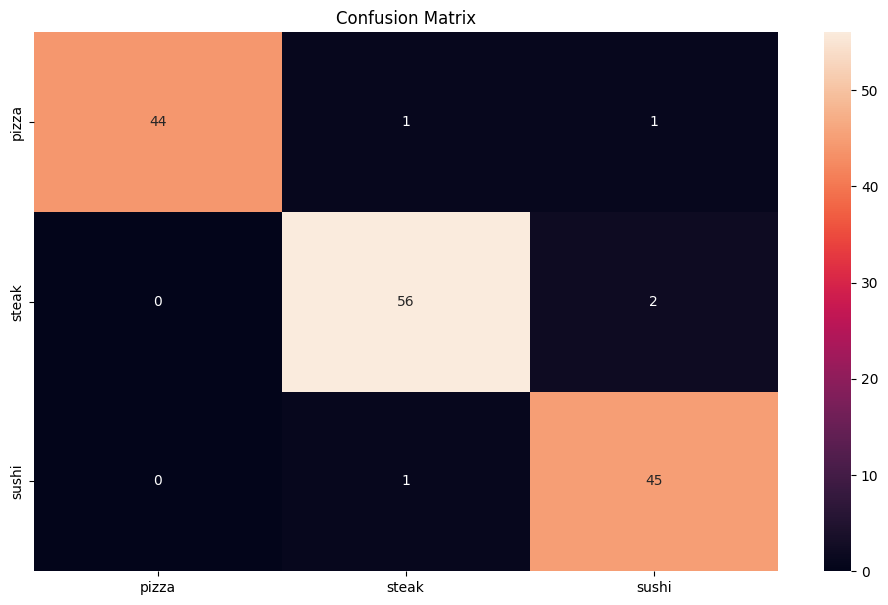

In [21]:
get_train_inf(effnetb2, effnetb2_results, test_dataloader = test_dataloader_effnetb2)

In [24]:
# Step 8
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="Models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())

[INFO] Saving model to: Models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [25]:
# Сохраним результаты в словарь для дальнейшего сравнения
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28171582221984864,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

# Загрузка модели ViT
1. Загружаем модель
2. Получаем трансформ для предобратки данных
3. Замораживаем все слои (нет необходимости снова их обучать)
4. Адаптируем последние слои под наш набор данных (пицца, стейки, роллы)
5. Подготовим данные
6. Обучим (загруженную модель) на нашем наборе данных
7. Оценим результаты обучения модели (кривые, матрица ошибок)
8. Сохранение модели на диск

In [26]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [27]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [28]:
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

In [29]:
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [30]:
# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


Making predictions:   0%|          | 0/5 [00:00<?, ?it/s]

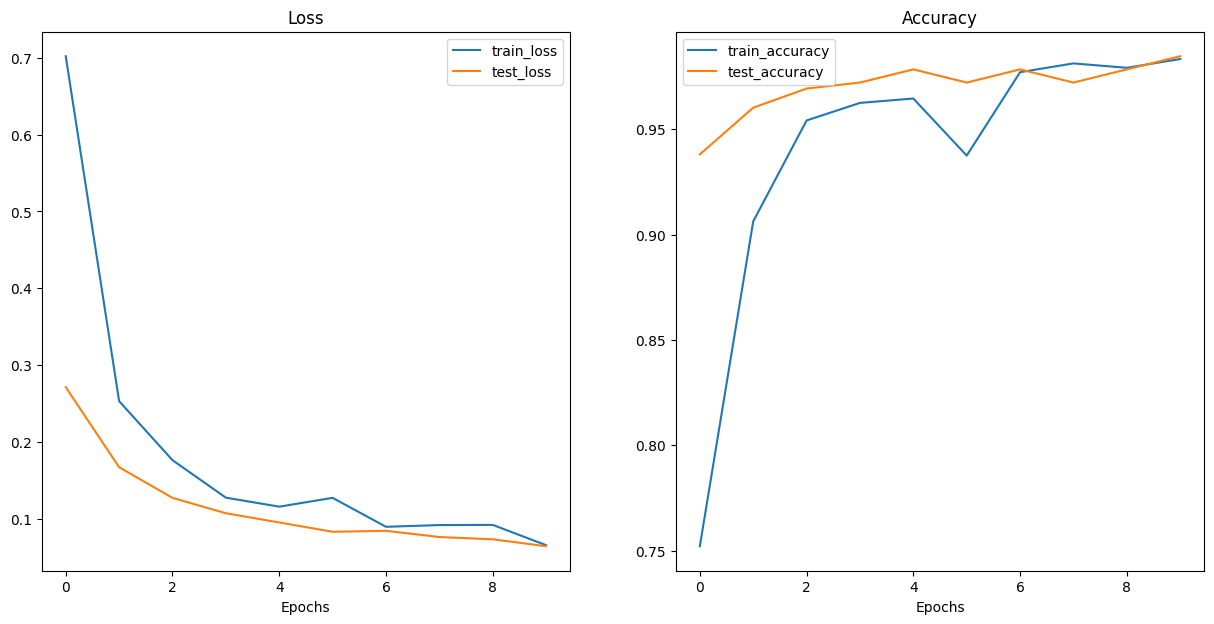

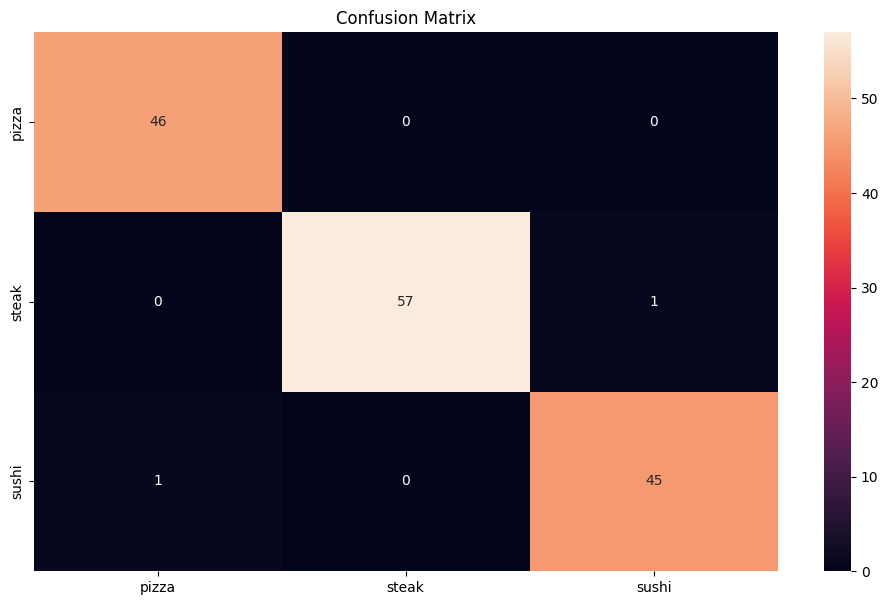

In [31]:
get_train_inf(vit, vit_results, test_dataloader = test_dataloader_vit)

In [32]:
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
vit_total_params = sum(torch.numel(param) for param in vit.parameters())

vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

[INFO] Saving model to: models\09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


{'test_loss': 0.06443452695384622,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

# Прогнозы обученных моделей на тестовых данных и замер времени выполнения
1. Создаем функцию прогнозирования данных и расчета времени на прогноз
2. Считаем 
3. Сохраням и сравниваем

In [34]:
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[WindowsPath('Dataset/pizza_steak_sushi_20/test/pizza/1001116.jpg'),
 WindowsPath('Dataset/pizza_steak_sushi_20/test/pizza/1032754.jpg'),
 WindowsPath('Dataset/pizza_steak_sushi_20/test/pizza/1067986.jpg'),
 WindowsPath('Dataset/pizza_steak_sushi_20/test/pizza/129666.jpg'),
 WindowsPath('Dataset/pizza_steak_sushi_20/test/pizza/1315645.jpg')]

In [36]:
# Функция для создания предсказаний модели и расчета замера времени (на предсказание) # Todo - save def to engine.py
import pathlib
from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list


In [48]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 

  0%|          | 0/150 [00:00<?, ?it/s]

In [54]:
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
print(effnetb2_test_pred_df.correct.value_counts())

effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
print(effnetb2_stats)

True     145
False      5
Name: correct, dtype: int64
EffNetB2 average time per prediction: 0.1033 seconds
{'test_loss': 0.28171582221984864, 'test_acc': 0.96875, 'number_of_parameters': 7705221, 'model_size (MB)': 29, 'time_per_pred_cpu': 0.1033}


In [55]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [56]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
print(vit_test_pred_df.correct.value_counts())

vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"Vit average time per prediction: {vit_average_time_per_pred} seconds")

vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
print(vit_stats)

True     148
False      2
Name: correct, dtype: int64
Vit average time per prediction: 0.1761 seconds
{'test_loss': 0.06443452695384622, 'test_acc': 0.984659090909091, 'number_of_parameters': 85800963, 'model_size (MB)': 327, 'time_per_pred_cpu': 0.1761}


# Сравнение результатов обучение и прогноза моделей
1. Создадим датафрейм с результатами моделей
2. Проведем перекрестную проверку результатов моделей

In [58]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281716,96.88,7705221,29,0.1033,EffNetB2
1,0.064435,98.47,85800963,327,0.1761,ViT


In [61]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.228722,1.016412,11.135432,11.275862,1.704743


* 11x+ количество параметров.
* 11x+ размер модели.
* 1.70+ раза больше времени предсказания на изображение.

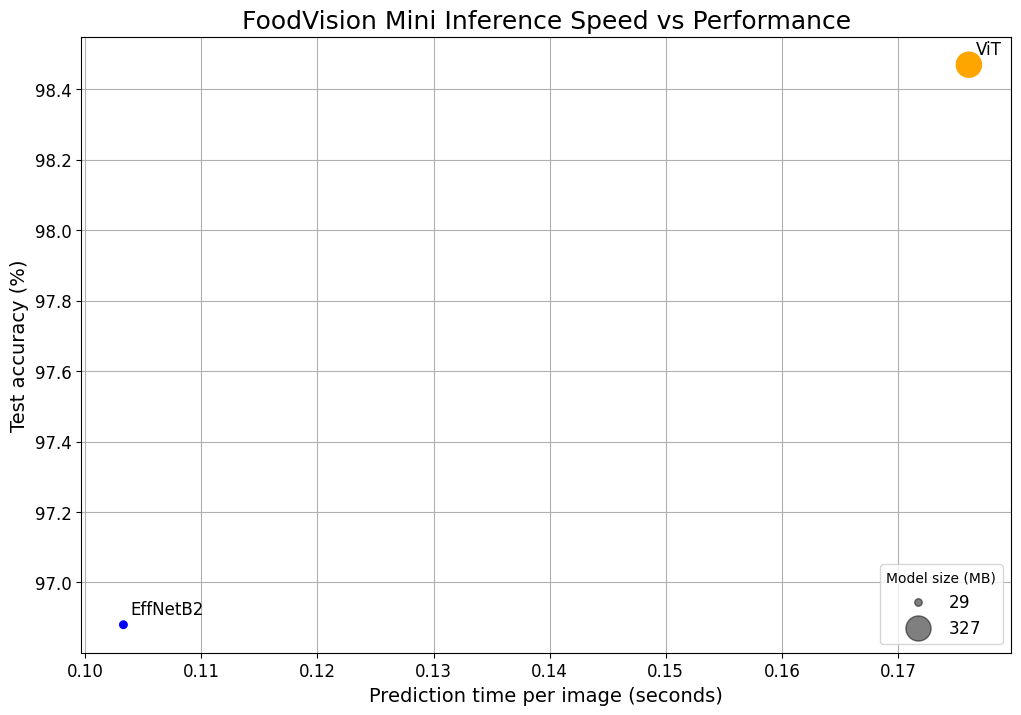

In [63]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
#plt.savefig()

# Show the figure
plt.show()

# Развертывание модели 

In [66]:
import gradio as gr

In [68]:
# Функция прогнозирования 
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [70]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: Dataset\pizza_steak_sushi_20\test\steak\3173402.jpg

Prediction label and probability dictionary: 
{'pizza': 0.0915144681930542, 'steak': 0.897412121295929, 'sushi': 0.01107352040708065}
Prediction time: 0.08911 seconds


In [71]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['Dataset\\pizza_steak_sushi_20\\test\\pizza\\482858.jpg'],
 ['Dataset\\pizza_steak_sushi_20\\test\\sushi\\3365273.jpg'],
 ['Dataset\\pizza_steak_sushi_20\\test\\steak\\108310.jpg']]

# Реализация 
1. Входные данные
2. Модель (обработка)
3. Результат

In [73]:
title = "FoodVision 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Bla"

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), 
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://db5813a721d978dcb8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [74]:
demo.close()

Closing server running on port: 7860
